In [ ]:
# 1. 과거 주가 정보를 수집하는 방법
# 2. 시계열 예측 작업을 위한 데이터셋 형식을 구성하는 방법
# 3. 회귀 모델을 사용해 미래 주가를 예측하는 방법
# 4. 장단기 메모리(Long short-term memory, LSTM) 기초
# 5. LSTM으로 예측 성능을 높이는 방법
# 6. 텐서보드(Tensorboard)에 성능을 시각화하는 방법

In [1]:
import numpy as np

### 입력 데이터셋 - 코사인과 주가

In [ ]:
# 시계열 데이터로 두 개의 일차원 신호를 사용

In [32]:
# 1. 균일한 잡음이 추가된 코사인파
# 점의 개수, 신호 주기, 균일한 잡음 생성기의 절대 강도가 매개변수로 주어졌을 때
# 코사인 신호를 생성하는 함수

def fetch_cosine_values(seq_len, frequency = 0.01, noise = 0.1) :
    # random seed를 설정해 실험을 복제할 수 있게 한다
    np.random.seed(101)
    x = np.arange(0.0, seq_len, 1.0)
    return np.cos(2 * np.pi * frequency * x) + np.random.uniform(low=-noise, high=noise, size=seq_len)

In [33]:
# 10개의 점, 0.1 크기의 잡음이 추가된 코사인의 전체 진동(따라서 주기가 0.1)을 한 번 출력
print(fetch_cosine_values(10, frequency=0.1))

[ 1.00327973  0.82315051  0.21471184 -0.37471266 -0.7719616  -0.93322063
 -0.84762375 -0.23029438  0.35332577  0.74700479]


In [45]:
# print(np.arange(0.0, 10, 1.0))
# x = np.arange(0.0, 10, 1.0)

In [46]:
# print(2 * np.pi * 0.1 * x)

In [47]:
# # np.pi : 3.141592653589793
# np.cos(2 * np.pi * 0.1 * x)

In [48]:
# np.random.seed(101)
# np.cos(2 * np.pi * 0.1 * x) + np.random.uniform(low=-0.1, high=0.1, size=10)

In [ ]:
# 2. 실제 금융권
# 파이썬 라이브러리 : quandl

In [ ]:
# $ curl "https://www.quandl.com/api/v3/datasets/WIKI/FB/data.csv"

In [4]:
s1 = "Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume"
s2 = "2018-03-27,156.31,162.85,150.75,152.19,76787884.0,0.0,1.0,156.31,162.85,150.75,152.19,76787884.0"

# print(s1.split(','))
# print(s2.split(','))

dic = {}
for i, j in zip(s1.split(','), s2.split(',')) :
    dic[i] = j
print(dic)

{'Date': '2018-03-27', 'Open': '156.31', 'High': '162.85', 'Low': '150.75', 'Close': '152.19', 'Volume': '76787884.0', 'Ex-Dividend': '0.0', 'Split Ratio': '1.0', 'Adj. Open': '156.31', 'Adj. High': '162.85', 'Adj. Low': '150.75', 'Adj. Close': '152.19', 'Adj. Volume': '76787884.0'}


In [ ]:
# .csv
# 날짜, 시가, 고가, 저가, 종가, 조정가, 몇 가지 거래량, *조정 마감가*

In [ ]:
# 파이썬 API를 사용해 조정가를 추출하는 파이썬 함수
# https://docs.quandl.com/v1.0/docs

In [5]:
import os
import pickle

In [6]:
# $ pip install quandl
import quandl

In [7]:
# datetime.date를 API에서 필요로 하는 적합한 문자열 형식으로 변환하는 헬퍼 함수
def date_obj_to_str(date_obj) :
    return date_obj.strftime('%Y-%m-%d')

In [25]:
# pickle
# dump

In [8]:
def save_pickle(something, path) :
    if not os.path.exists(os.path.dirname(path)) :
        os.makedirs(os.path.dirname(path))
    with open(path, 'wb') as fh :
        pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)

In [9]:
# def load_pickle(path) :
#     with open(path, 'rb') as fh :
#        return pickle.load(fh)

def load_pickle(path) :
    with open(path, 'rb') as fh :
        return pickle.load(fh)

In [10]:
quandl.ApiConfig.api_key = "b8siLwjzBZf5VMF28m9L"

In [11]:
# 해당 종목 기호에 대한 과거 데이터를 가져오기 위해 
# 호출 결과를 캐시에 저장하고 가져올 데이터의 시작과 끝의 타임스탬프를 지정할 수 있어야 한다.

# 일차원 배열로 요청한 종목 기호에 대한 주가를 포함하고 있으며,
# from_date에서 to_date로 정렬되어 있다

# 캐싱은 함수 내에서 이뤄지며,
# 이는 데이터가 캐시에서 발견되지 않으면 quandle API가 호출됨을 뜻한다
def fetch_stock_price(symbol, from_date, to_date, cache_path = './tmp/prices/') :
    assert(from_date <= to_date)
    filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
    price_filepath = os.path.join(cache_path, filename)
    try :
        prices = load_pickle(price_filepath)
        print("loaded from", price_filepath)
    except IOError :
        historic = quandl.get("WIKI/" + symbol, 
                              start_date = date_obj_to_str(from_date), 
                              end_date = date_obj_to_str(to_date))
        prices = historic["Adj. Close"].tolist()
        save_pickle(prices, price_filepath)
        print("saved into", price_filepath)
    return prices

In [13]:
# import os
# import pickle
# import quandl
# import numpy as np


# def date_obj_to_str(date_obj):
#     return date_obj.strftime('%Y-%m-%d')


# def save_pickle(something, path):
#     if not os.path.exists(os.path.dirname(path)):
#         os.makedirs(os.path.dirname(path))
#     with open(path, 'wb') as fh:
#         pickle.dump(something, fh, pickle.DEFAULT_PROTOCOL)


# def load_pickle(path):
#     with open(path, 'rb') as fh:
#         return pickle.load(fh)


# def fetch_stock_price(symbol,
#                       from_date,
#                       to_date,
#                       cache_path="./tmp/prices/"):
#     assert(from_date <= to_date)

#     filename = "{}_{}_{}.pk".format(symbol, str(from_date), str(to_date))
#     price_filepath = os.path.join(cache_path, filename)

#     try:
#         prices = load_pickle(price_filepath)
#         print("loaded from", price_filepath)

#     except IOError:
#         historic = quandl.get("WIKI/" + symbol,
#                               start_date=date_obj_to_str(from_date),
#                               end_date=date_obj_to_str(to_date))

#         prices = historic["Adj. Close"].tolist()
#         save_pickle(prices, price_filepath)
#         print("saved into", price_filepath)

#     return prices

In [15]:
import datetime

In [17]:
# 2017.01 구글 주가(종목 기호 : GOOG) 조정가 출력
# print(fetch_stock_price("GOOG", datetime.date(2017, 1, 1), datetime.date(2017, 1, 31)))

### 데이터셋 포맷 구성

In [ ]:
def format_dataset(values, temporal_features) :
    # feat_splits = [ values[i:i+temporal_features] for i in range(len(values) - temporal_features) ]
    feat_splits = []
    for i in range(len(values) - temporal_features) :
        feat_splits.append(values[i:i+temporal_features])
    
    # 모든 관측값은 레이블과 함께 세로로 연결
    feats = np.vstack(feat_splits)
    labels = np.array(values[temporal_features :])
    
    # 정해진 개수의 열을 갖는 관측값과 레이블 벡터
    return feats, labels

C:\Users\User\Anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


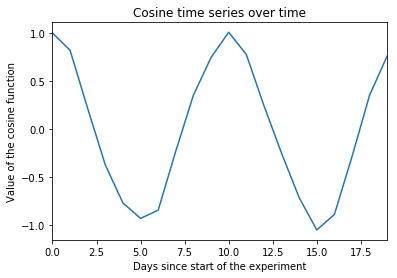

In [41]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn

from tools import fetch_cosine_values, fetch_stock_price, format_dataset
np.set_printoptions(precision=2)

# Print 2 oscillations (20 points, with a frequency of 0.1, i.e. a period of 10)
# 주기 10, 20개의 점을 갖는 코사인 시계열
cos_values = fetch_cosine_values(20, frequency = 0.1)
seaborn.tsplot(cos_values)
plt.xlabel("Days since start of the experiment")
plt.ylabel("Value of the cosine function")
plt.title("Cosine time series over time")
plt.show()

In [50]:
print(cos_values)

[ 1.    0.82  0.21 -0.37 -0.77 -0.93 -0.85 -0.23  0.35  0.75  1.01  0.78
  0.25 -0.25 -0.72 -1.05 -0.89 -0.29  0.35  0.76]


In [51]:
print(cos_values.shape)

(20,)


In [81]:
# features_size = 5

In [82]:
# features_splits = []
# for i in range(len(cos_values) - features_size) :
#     # print(cos_values[i:i+features_size])
#     features_splits.append(cos_values[i:i+features_size])

In [83]:
# features_splits

In [84]:
# feats = np.vstack(features_splits)

In [85]:
# feats

In [54]:
# 위 시계열 데이터를
# 머신러닝 알고리즘에서 받아들일 수 있는 형식으로 바꿔서
# 5개의 열을 갖는 관측행렬을 만든다

features_size = 5
minibatch_cos_X , minibatch_cos_y = format_dataset(cos_values, features_size)
print('minibatch_cos_X.shape', minibatch_cos_X.shape)
print('minibatch_cos_y.shape', minibatch_cos_y.shape)

minibatch_cos_X.shape (15, 5)
minibatch_cos_y.shape (15,)


In [86]:
# 15x5 크기의 관측값 행렬
minibatch_cos_X

array([[ 1.  ,  0.82,  0.21, -0.37, -0.77],
       [ 0.82,  0.21, -0.37, -0.77, -0.93],
       [ 0.21, -0.37, -0.77, -0.93, -0.85],
       [-0.37, -0.77, -0.93, -0.85, -0.23],
       [-0.77, -0.93, -0.85, -0.23,  0.35],
       [-0.93, -0.85, -0.23,  0.35,  0.75],
       [-0.85, -0.23,  0.35,  0.75,  1.01],
       [-0.23,  0.35,  0.75,  1.01,  0.78],
       [ 0.35,  0.75,  1.01,  0.78,  0.25],
       [ 0.75,  1.01,  0.78,  0.25, -0.25],
       [ 1.01,  0.78,  0.25, -0.25, -0.72],
       [ 0.78,  0.25, -0.25, -0.72, -1.05],
       [ 0.25, -0.25, -0.72, -1.05, -0.89],
       [-0.25, -0.72, -1.05, -0.89, -0.29],
       [-0.72, -1.05, -0.89, -0.29,  0.35]])

In [87]:
# 15개의 요소를 갖는 레이블 벡터
minibatch_cos_y

array([-0.93, -0.85, -0.23,  0.35,  0.75,  1.01,  0.78,  0.25, -0.25,
       -0.72, -1.05, -0.89, -0.29,  0.35,  0.76])

Observation 0 : X=[ 1.    0.82  0.21 -0.37 -0.77] y=-0.9332206274727847
Observation 1 : X=[ 0.82  0.21 -0.37 -0.77 -0.93] y=-0.8476237504404999
Observation 2 : X=[ 0.21 -0.37 -0.77 -0.93 -0.85] y=-0.23029437843826808
Observation 3 : X=[-0.37 -0.77 -0.93 -0.85 -0.23] y=0.35332576672860816
Observation 4 : X=[-0.77 -0.93 -0.85 -0.23  0.35] y=0.7470047852159067


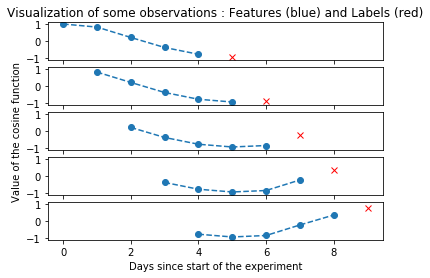

In [105]:
# 시각화
samples_to_plot = 5
f, axarr = plt.subplots(samples_to_plot, sharex = True)
for i in range(samples_to_plot) :
    feats = minibatch_cos_X[i, :]
    label = minibatch_cos_y[i]
    print("Observation {} : X={} y={}".format(i, feats, label))
    
    # plt.subplot(samples_to_plot, 1, i+1)
    axarr[i].plot(range(i, features_size+i), feats, '--o')
    axarr[i].plot([features_size+i], label, 'rx')
    axarr[i].set_ylim([-1.1, 1.1])

plt.xlabel("Days since start of the experiment")
axarr[2].set_ylabel("Value of the cosine function")
axarr[0].set_title("Visualization of some observations : Features (blue) and Labels (red)")
plt.show()

In [124]:
# os.path.join("./tmp/prices/", "MSFT_2015-01-01_2016-12-31.pk")
# './tmp/prices/MSFT_2015-01-01_2016-12-31.pk'

loaded from ./tmp/prices/MSFT_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/KO_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/AAL_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/MMM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/AXP_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/GE_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/GM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/JPM_2015-01-01_2016-12-31.pk
loaded from ./tmp/prices/UPS_2015-01-01_2016-12-31.pk


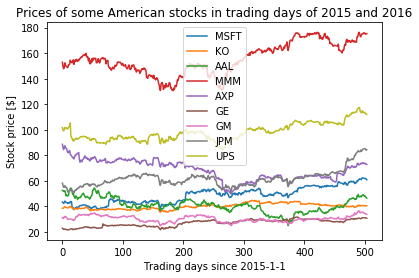

In [140]:
symbols = ["MSFT", "KO", "AAL", "MMM", "AXP", "GE", "GM", "JPM", "UPS"]
ax = plt.subplot(1, 1, 1)
for sym in symbols :
    prices = fetch_stock_price(sym, datetime.date(2015, 1, 1), datetime.date(2016, 12, 31))
    ax.plot(range(len(prices)), prices, label = sym)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.xlabel("Trading days since 2015-1-1")
plt.ylabel("Stock price [$]")
plt.title("Prices of some American stocks in trading days of 2015 and 2016")
plt.show()

In [139]:
# handles, labels = ax.get_legend_handles_labels()
# handles, labels

In [133]:
# historic = quandl.get("WIKI/" + "MSFT", start_date=date_obj_to_str(datetime.date(2015, 1, 1)), end_date=date_obj_to_str(datetime.date(2016, 12, 31)))

In [134]:
# historic["Adj. Close"]

In [135]:
# historic["Adj. Close"].tolist()

### 회귀 모델을 이용한 미래 주가 예측

In [ ]:
# 관측 행렬과 실제 값 레이블이 주어지면 
# 처음에는 이 문제를 회귀 문제로 풀고 싶기 마련이다.
# 이 경우 회귀는 매우 간단
# 수치 벡터에서 수치 값을 예측하는 것
# => 이상적인 방법이 아니다

# 문제를 회귀 문제로 다루게 되면
# 알고리즘은 각 특징이 독립적이라고 간주해야 한다
# 그러나 이 예제에서 각 특징은
# 동일한 시계열의 슬라이딩 윈도우이므로 서로 상관되어 있다

# 우선 '각 특징이 독립적'이라는 단순한 가정에서 시작

In [ ]:
# 행렬을 일차원 배열로 변환하는 헬퍼 함수
def matrix_to_array(m) :
    return np.asarray(m).reshape(-1)

In [ ]:
# 평가 함수

import numpy as np
from matplotlib import pylab as plt
from tools import matrix_to_array

def evaluate_ts(features, y_true, y_pred) :
    print("Evaluation of the predictions :")
    print("MSE : ", np.mean(np.square(y_true - y_pred)))
    print("MAE : ", np.mean(np.abs(y_true - y_pred)))
    
    print("Benchmark : if prediction == last feature")
    print("MSE : ", np.mean(np.square(features[:, -1] - y_true)))
    print("mae : ", np.mean(np.abs(features[:, -1] - y_true)))
    
    plt.plot(matrix_to_array(y_true), 'b')
    plt.plot(matrix_to_array(y_pred), 'r--')
    plt.xlabel("Days")
    plt.ylabel("Predicted and true values")
    plt.title("Predicted (Red) VS Real (Blue)")
    plt.show()
    
    error = np.abs(matrix_to_array(y_pred) - matrix_to_array(y_true))
    plt.plot(error, 'r')
    fit = np.polyfit(range(len(error)), error, deg = 1)
    plt.plot(fit[0] * range(len(error)) + fit[1], '--')
    plt.xlabel("Days")
    plt.ylabel("Prediction error L1 norm")
    plt.title("Prediction error (absolute) and trendline")
    plt.show()

In [ ]:
# 모델링
# regression_cosine

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from evaluate_ts import evaluate_ts
from tensorflow.contrib import rnn
from tools import fetch_cosine_values, format_dataset

tf.reset_default_graph()
tf.set_random_seed(101)

# Settings for the dataset creation
# 특징 크기로 대략 한 달의 영업일수에 해당하는 20을 사용
# => 과거 코사인의 값이 20개가 주어졌을 때 다음 날의 값을 예측하는 문제
feat_dimension = 20
train_size = 250
test_size = 250

# Settings for tensorflow
# 1. 학습 속도
# 2. 사용할 최적화 알고리즘
# 3. 세대 수(훈련시킬 때 훈련 데이터셋이 학습 모델에 얼마나 많이 들어가는지)
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer
n_epochs = 10

cos_values = fetch_cosine_values(train_size + test_size + feat_dimension)
minibatch_cos_X, minibatch_cos_y = format_dataset(cos_values, feat_dimension)
train_X = minibatch_cos_X[:train_size, :].astype(np.float32)
train_y = minibatch_cos_y[:train_size].astype(np.float32)

In [150]:
cos_values = fetch_cosine_values(250 + 250 + 20)
minibatch_cos_X, minibatch_cos_y = format_dataset(cos_values, 20)

In [156]:
# print(minibatch_cos_y[:250].reshape(-1, 1))
'''
[[ 3.46e-01]
 [ 2.52e-01]
 [ 9.71e-02]
 [ 5.29e-02]
 [ 1.84e-04]
 [ 9.89e-02]
 ...
 [-6.76e-01]
 [-5.23e-01]
 [-5.22e-01]
 [-5.32e-01]
 [-5.23e-01]
 [-4.02e-01]]
'''

'\n[[ 3.46e-01]\n [ 2.52e-01]\n [ 9.71e-02]\n [ 5.29e-02]\n [ 1.84e-04]\n [ 9.89e-02]\n ...\n [-6.76e-01]\n [-5.23e-01]\n [-5.22e-01]\n [-5.32e-01]\n [-5.23e-01]\n [-4.02e-01]]\n'